# Visualizing Price Movement

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm

In [2]:
#path to the data folder, edit if necesssary
path = "./data/"

#filenames
file_power = "competitor_market_prices_power.csv"
file_gas = "competitor_market_prices_gas.csv"
master_power = "master_competitor_market_prices_power.csv"
master_gas = "master_competitor_market_prices_gas.csv"

#Price Filenames
power_prices = 'power_prices'
gas_prices = 'gas_prices'

In [3]:
#Reading in gas and power prices
df_power_prices = pd.read_csv(path + power_prices, index_col = 'Dates')
df_gas_prices = pd.read_csv(path + gas_prices, index_col = 'date')

In [4]:
#Reading in master data
df_power = pd.read_csv(path + master_power)
df_power.set_index(pd.to_datetime(df_power['date_valid_from']), inplace = True)
df_gas = pd.read_csv(path + master_gas)
df_gas.set_index(pd.to_datetime(df_gas['date_valid_from']), inplace = True)

#Fixing proper indexing
df_gas_prices.index = pd.to_datetime(df_gas_prices.index)
df_power_prices.index = pd.to_datetime(df_power_prices.index)

In [5]:
#Defining functions that subset our data for a certain consumption range, postcode and supplier name and prepares it for analysis.
#Average household prices are exploded across time period and grouped by validity dates.

def queryRangePostCode(consumption_range_kwh = 2000, post_code = 81737) -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.post_code == post_code)].copy()
    
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_year_eur':'mean', 'price_kwh':'mean'})
    return res

def queryPostCodeSupplier(post_code = 81737, supplier = 'Sarma') -> pd.DataFrame:
    res = df_power.loc[(df_power.post_code == post_code) & (df_power.supplier == supplier)].copy()
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_year_eur':'mean', 'price_kwh':'mean'})
    return res

In [6]:
#Defining function for price time series preparation.
#price_instrument -> str specifying desired price instrument
#model_type -> str, either 'ewm' or 'sma'
#days -> int, how many days is the model looking back for sma models, and maps to alpha (by dividing by 1000) for ewm models

def selectPriceTimeSeries(price_instrument = 'y_ahead_base', model_type = 'sma', days = 100) -> pd.DataFrame:
    if model_type == 'sma':
        res = df_power_prices[price_instrument]
        res = pd.DataFrame(res.rolling(days).mean())
    else:
        days /= 1000
        res = pd.DataFrame(df_power_prices[[price_instrument]].ewm(alpha = days, adjust = False).mean())
    return res

#Defining function to get most relevant price instrument timeseries combo as measured by linear regression R-squared
#price_instruments -> list of power price instruments to try
#household data -> daily aggregated mean household price data to regress upon

from sklearn.linear_model import LinearRegression

def getMostRelevantInstrument(household_data) -> str:

    #Model output which will be printed
    max_R2 = 0
    best_model_type = ''
    best_model_period = 0
    best_model_instrument = np.NAN
    price_instruments = ['spot_base', 'y_ahead_base', 'y_ahead_peak', '6m_ahead_peak', '3y_ahead_base', 'm_ahead_base', '6m_ahead_base']

    if household_data.shape[0] == 0:
        return best_model_instrument

    household_data.set_index(pd.to_datetime(household_data.index))
    models = ['sma', 'ewm']
    times = [100, 200, 300]

    for instrument in price_instruments:
        for model in models:
            for time in times:
                timeseries = selectPriceTimeSeries(instrument, model, time)
                temp = household_data.merge(timeseries, left_index = True, right_index = True, how = 'inner')

                X = temp[[instrument]]
                Y = np.array(temp.price_kwh)

                lm = LinearRegression()
                reg = lm.fit(X,Y)
                score = reg.score(X,Y)

                if score > max_R2:
                    max_R2 = score
                    best_model_type = model
                    best_model_instrument = instrument
                    best_model_period = time
                    
    return best_model_instrument


In [7]:
#Creating df which stores most important price for top 100 suppliers across top 10 postcodes

#Getting Top 100 suppliers
df_top_suppliers = pd.DataFrame(df_power.supplier.value_counts().head(100))
df_top_suppliers.reset_index(inplace=True)
df_top_suppliers.rename(columns={'index': 'supplier', 'supplier': 'count'}, inplace=True)

#Getting Top 10 postcodes
top_postcodes = df_power.post_code.value_counts().head(10)

#Generating Post Code Columns containing most important instrument and model info for top 10 postcodes (Takes around 20 min)
for postcode in top_postcodes.index:
    print(postcode) #prints out postcode to tell you how far along the calculation is
    df_top_suppliers[postcode] = df_top_suppliers.apply(lambda x: getMostRelevantInstrument(queryPostCodeSupplier(postcode, x['supplier'])), axis = 1)

df_top_suppliers

21423
24109
48161
85055
72108
53229
76137
59071
31789
54294


,supplier,count,21423,24109,48161,85055,72108,53229,76137,59071,31789,54294
0,Sarma,1832747,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,m_ahead_base,spot_base,m_ahead_base,m_ahead_base,y_ahead_peak,m_ahead_base
1,Bergwind,1442630,y_ahead_peak,y_ahead_peak,y_ahead_peak,y_ahead_peak,y_ahead_base,y_ahead_peak,y_ahead_base,y_ahead_peak,y_ahead_peak,y_ahead_peak
2,Caurus,1342179,spot_base,spot_base,spot_base,spot_base,spot_base,spot_base,spot_base,spot_base,spot_base,spot_base
3,Pulenat,1181005,y_ahead_peak,y_ahead_peak,6m_ahead_peak,6m_ahead_peak,spot_base,y_ahead_peak,y_ahead_peak,6m_ahead_peak,6m_ahead_peak,6m_ahead_peak
4,Belat,1136882,spot_base,6m_ahead_peak,6m_ahead_peak,6m_ahead_peak,y_ahead_peak,spot_base,6m_ahead_peak,6m_ahead_peak,6m_ahead_peak,6m_ahead_peak
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Himmelsbesen,19010,6m_ahead_base,6m_ahead_base,6m_ahead_base,spot_base,spot_base,spot_base,spot_base,6m_ahead_base,spot_base,y_ahead_base
96,Oroshi,16166,6m_ahead_base,6m_ahead_base,NaN,NaN,NaN,spot_base,6m_ahead_base,NaN,NaN,NaN
97,Maloja,15878,spot_base,m_ahead_base,spot_base,spot_base,NaN,spot_base,spot_base,spot_base,6m_ahead_base,spot_base
98,Taifun,15340,NaN,NaN,NaN,y_ahead_peak,y_ahead_peak,NaN,spot_base,NaN,NaN,NaN


In [8]:
#Dropping count column and adding mode column for most important price across postcodes
df_top_suppliers.drop('count', inplace=True, axis = 1)
df_top_suppliers['most_important_price'] = df_top_suppliers.apply(lambda x: x.mode(dropna = True)[0], axis = 1)

In [9]:
#Adding strategy indices for suppliers
df_strat_index = pd.DataFrame(df_power.groupby('supplier').agg({'strat_index':'mean'}))
df_strat_index.reset_index(inplace=True)
df_top_suppliers = df_top_suppliers.merge(df_strat_index, on = 'supplier', how= 'left')

In [10]:
df_top_suppliers[['supplier', 'most_important_price', 'strat_index']].most_important_price.value_counts()

m_ahead_base     23
y_ahead_peak     19
spot_base        19
6m_ahead_base    15
6m_ahead_peak    11
3y_ahead_base     6
y_ahead_base      5
Baguio            1
Chinook           1
Name: most_important_price, dtype: int64

In [11]:
#Looking at price volatility across supplier indices
df_power_1 = df_power.loc[df_power.strat_index == 1].copy()
df_power_2 = df_power.loc[df_power.strat_index == 2].copy()
df_power_3 = df_power.loc[df_power.strat_index == 3].copy()
df_power_4 = df_power.loc[df_power.strat_index == 4].copy()
df_power_5 = df_power.loc[df_power.strat_index == 5].copy()

#Looking at average gross margins
df_power_1['avg_margin'] = (df_power_1.price_kwh - (df_power_1.avg_price)) / df_power_1.price_kwh
df_power_2['avg_margin'] = (df_power_2.price_kwh - (df_power_2.avg_price)) / df_power_2.price_kwh
df_power_3['avg_margin'] = (df_power_3.price_kwh - (df_power_3.avg_price)) / df_power_3.price_kwh
df_power_4['avg_margin'] = (df_power_4.price_kwh - (df_power_4.avg_price)) / df_power_4.price_kwh
df_power_5['avg_margin'] = (df_power_5.price_kwh - (df_power_5.avg_price)) / df_power_5.price_kwh

print(df_power_1.avg_margin.mean())
print(df_power_2.avg_margin.mean())
print(df_power_3.avg_margin.mean())
print(df_power_4.avg_margin.mean())
print(df_power_5.avg_margin.mean())

0.47415131410134304
0.5302576103507068
0.5612494021784911
0.6343315042922478
0.6663814613804384


In [12]:
def getDailyData(res) -> pd.DataFrame:
    res = res[['price_kwh', 'avg_margin', 'date_valid_from', 'date_valid_to']]

    res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
    res = res.explode("valid_range").copy()

    #Aggregating for mean household prices per day
    res = res.groupby('valid_range').agg({'price_kwh':'mean', 'avg_margin': 'mean'})
    return res

#Getting daily indexed agg price data and margins (takes 40 mins)
df_power_1 = getDailyData(df_power_1)
print('1')
df_power_2 = getDailyData(df_power_2)
print('2')
df_power_3 = getDailyData(df_power_3)
print('3')
df_power_4 = getDailyData(df_power_4)
print('4')
df_power_5 = getDailyData(df_power_5)
print('5')


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_53067/551705659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


1


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_53067/551705659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


2


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_53067/551705659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


3


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_53067/551705659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


4


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_53067/551705659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


5


In [13]:
#Preparing dfs for concatenation
df_power_2 = df_power_2.add_suffix('_2')
df_power_3 = df_power_3.add_suffix('_3')
df_power_4 = df_power_4.add_suffix('_4')
df_power_5 = df_power_5.add_suffix('_5')

In [25]:
#Visualizing average prices across supplier indices
df_index_prices = pd.concat([df_power_1, df_power_2, df_power_3, df_power_4, df_power_5], axis = 1)
df_index_prices.to_csv(path + 'index_power_prices', index = False)

In [22]:
df_power_2.avg_margin_2

valid_range
2021-05-25    0.904450
2021-05-26    0.904450
2021-05-27    0.904450
2021-05-28    0.904450
2021-05-29    0.904450
                ...   
2022-10-11    0.600130
2022-10-12    0.584458
2022-10-13    0.557574
2022-10-14    0.557574
2022-10-15    0.562520
Name: avg_margin_2, Length: 509, dtype: float64

In [38]:
print('Strategy index margin volatility:')
print(pd.concat([df_power_1.avg_margin, df_power_2.avg_margin_2, df_power_3.avg_margin_3, df_power_4.avg_margin_4, df_power_5.avg_margin_5], axis = 1).std())

print('Strategy index price volatility:')
print(pd.concat([df_power_1.price_kwh, df_power_2.price_kwh_2, df_power_3.price_kwh_3, df_power_4.price_kwh_4, df_power_5.price_kwh_5], axis = 1).std())

Strategy index margin volatility:
avg_margin      0.225915
avg_margin_2    0.174484
avg_margin_3    0.143729
avg_margin_4    0.123438
avg_margin_5    0.088680
dtype: float64
Strategy index price volatility:
price_kwh      0.084136
price_kwh_2    0.150383
price_kwh_3    0.164050
price_kwh_4    0.314003
price_kwh_5    0.096978
dtype: float64


<AxesSubplot: xlabel='valid_range'>

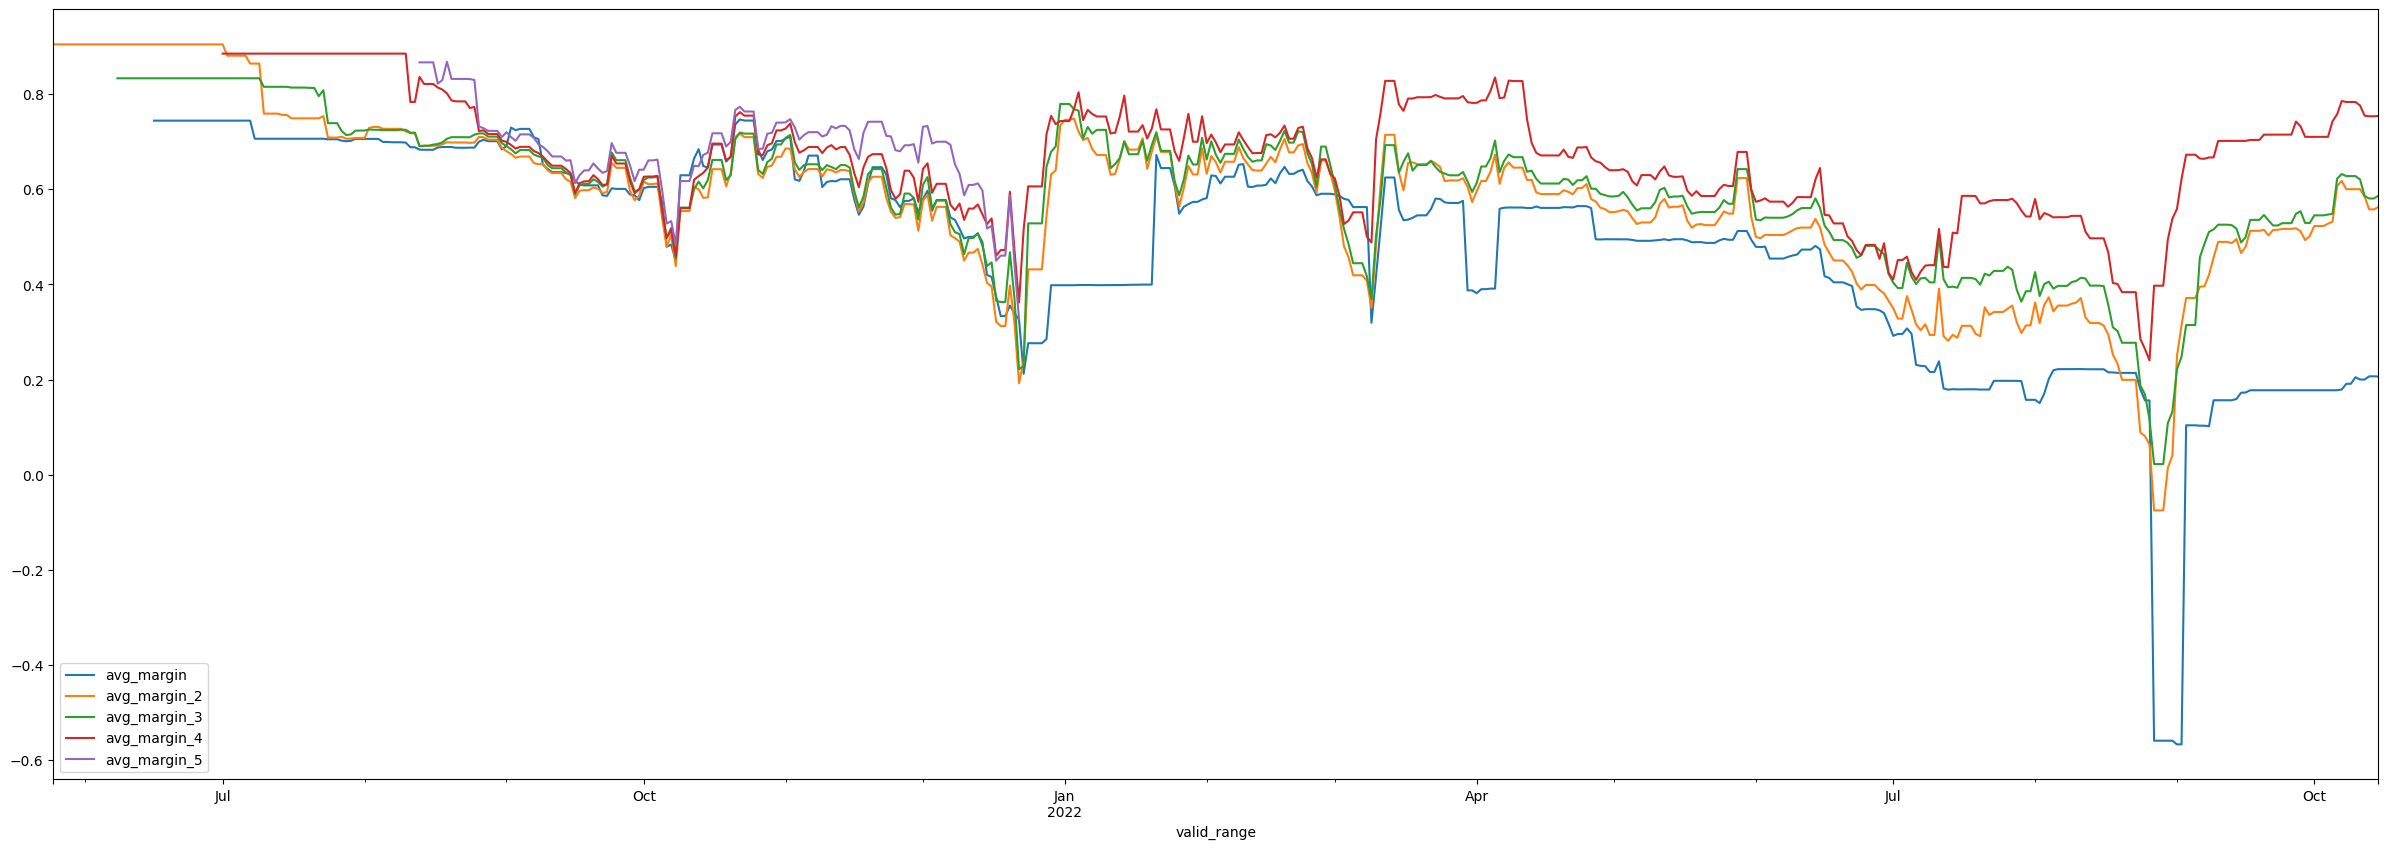

In [41]:
pd.concat([df_power_1['avg_margin'], df_power_2['avg_margin_2'], df_power_3['avg_margin_3'], df_power_4['avg_margin_4'], df_power_5['avg_margin_5']], axis= 1).plot(figsize=(30,10))